In [1]:
# Imports for the Maptek Python SDK and additional libraries.
import collections
import copy
import ctypes
import fractions
import math
import time
from collections import defaultdict
from itertools import islice

import matplotlib as mpl
import matplotlib.colors as cc

# mpl.use('agg')
import matplotlib.pyplot as cm
import numpy as np
import pandas as pd
import seaborn as sns
from mapteksdk.data import (
    DenseBlockModel,
    GridSurface,
    NumericColourMap,
    SubblockedBlockModel,
    Surface,
    Text3D,
)
from mapteksdk.project import Project
from matplotlib.ticker import PercentFormatter
from matplotlib.widgets import Button, CheckButtons, RadioButtons
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tqdm import tqdm_gui
from tqdm.notebook import tqdm, trange

cm.rcParams["font.family"] = ["Source Han Sans TW", "monospace"]
cm.rcParams["font.size"] = 14

# Connect to the currently running Maptek Project.
project = Project()
# project.mcp_instance.mcp_dict['PRODUCT_LOCATION_INFO']  # Report out which application it connected to (Optional)

In [2]:
# Initialisation
selected_model = None
selected_var = ""
colours = ""
real_colours = []
vis = ""
# ****************Bool swicthes for certain features*****************************************************************
vis_compiler = False
point_checker = True
# ********************************************************************************************************************
names = []
df = pd.DataFrame()
selection = project.get_selected()
last_opacity = 255

# For getting colours and the mapped names used in the model visualisation
# np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
with project.edit("legends/Domain 2") as legend:
    colours = legend.colours
    colour_names = legend.legend
    colour_names = [each_string.lower() for each_string in colour_names]
# Getting hex values of the colours
colours = colours / 255
for z in range(0, len(colour_names), 1):
    real_colours.append(cc.to_hex(colours[z], keep_alpha=True))

# Creating the array for storing data to be retrieved
N = len(colour_names)
global M
M = len(selection)
values = [[0 for i in range(M)] for j in range(N)]
vis_collection = [0] * M
var_collection = [0] * M
index_map = [0] * M
extents = [[] for _ in range(M)]
# i tells you the index of the block_model
i = 0
j = 0


# DATA GETTER

for item in selection:
    print(item.name)
    # Setting outer array back to 0, for new block
    j = 0
    nn = 0
    if item.is_a(DenseBlockModel) or item.is_a(SubblockedBlockModel):
        selected_model = item
        # Checker for point stuff
        if point_checker:
            # Getting all block details
            with project.edit(selected_model) as bm:

                block_sizes = bm.block_sizes
                block_centroids = bm.block_centroids
                b = bm.block_resolution
                x_res = float(b[0])
                y_res = float(b[1])
                z_res = float(b[2])

                x_count = bm.column_count
                y_count = bm.row_count
                z_count = bm.slice_count

                totallength_x_dimension = x_res * x_count
                totallength_y_dimension = y_res * y_count
                totallength_z_dimension = z_res * z_count

                index_map[i] = bm.block_to_grid_index
                index_map[i] = index_map[i].tolist()
                number_of_parent_blocks = len(np.unique(index_map[i], axis=0))
                total_volume_of_block = number_of_parent_blocks * x_res * y_res * z_res

                # Converting from world coordinates
                block_centroids = bm.convert_to_block_coordinates(block_centroids)
                block_centroids = block_centroids + 0.5 * np.array(
                    [x_res, y_res, z_res]
                )
                # Getting sample point data for point to block comparison
                point_location = "samples/res Intervals Table mid points"
                with project.read(point_location) as points:
                    # SDK method
                    real_points = points.points
                    point_visibility = points.point_visibility
                    real_points = bm.convert_to_block_coordinates(real_points)
                    real_points = real_points + 0.5 * np.array([x_res, y_res, z_res])
                    point_collection = [0] * len(real_points)
                    point_domains = points.point_attributes[
                        '{"c":"Domain","n":[],"s":"Point attribute (text)","t":"Tstring","u":"dimensionless","v":3}'
                    ]

                # *************************************************************************************************
                # Brute-force method
                print("Calculating block extents")

                for nn, useless_var in enumerate(block_centroids):
                    # print(len(extents[0]))
                    # print(len(extents[1]))
                    extents[i].append((
                        [
                            (block_centroids[nn] - block_sizes[nn] / 2).tolist(),
                            (block_centroids[nn] + block_sizes[nn] / 2).tolist(),
                        ]
                    ))

                print(len(extents[0]))
                print(len(extents[1]))
                # *************************************************************************************************
                # # Checks all attributes of block and then chooses the one with discrete values
                a_dict = bm.block_attributes.names
                for key in a_dict:
                    checker = bm.block_attributes[key]
                    if isinstance(checker[0], (str, int)):
                        selected_var = checker
                        var_collection[i] = selected_var
                vis = bm.block_visibility
                vis_collection[i] = vis
                for domain in colour_names:
                    values[j][i] = np.count_nonzero(selected_var == domain)
                    j = j + 1
                # Creating labels
                names.append("Block" + str(i))
                # For the confusion matrix
                df["block" + str(i)] = pd.Series(selected_var)
                i = i + 1


# Getting "number of blocks" and the cooridnates of all those blocks
# in the subblock model created for subblock-subblock comparison
# ###################################################################################################################
x_for_created_subblock = fractions.gcd(10, 10)
y_for_created_subblock = fractions.gcd(10, 10)
z_for_created_subblock = fractions.gcd(10, 10)
number_of_blocks_in_created_subblock_model = (total_volume_of_block) / (
    x_for_created_subblock * y_for_created_subblock * z_for_created_subblock
)

new_subblock_count_x_direction = totallength_x_dimension / x_for_created_subblock
new_subblock_count_y_direction = totallength_y_dimension / y_for_created_subblock
new_subblock_count_z_direction = totallength_z_dimension / z_for_created_subblock

new_x_centroid_coordinate = np.linspace(
    x_for_created_subblock / 2,
    (new_subblock_count_x_direction * x_for_created_subblock)
    + x_for_created_subblock / 2,
    int(new_subblock_count_x_direction),
    endpoint=False,
)

new_y_centroid_coordinate = np.linspace(
    y_for_created_subblock / 2,
    (new_subblock_count_y_direction * y_for_created_subblock)
    + y_for_created_subblock / 2,
    int(new_subblock_count_y_direction),
    endpoint=False,
)

new_z_centroid_coordinate = np.linspace(
    z_for_created_subblock / 2,
    (new_subblock_count_z_direction * z_for_created_subblock)
    + z_for_created_subblock / 2,
    int(new_subblock_count_z_direction),
    endpoint=False,
)


all_new_x_coordinates, all_new_y_coordinates, all_new_z_coordinates = np.meshgrid(
    new_x_centroid_coordinate,
    new_y_centroid_coordinate,
    new_z_centroid_coordinate,
    indexing="ij",
)

new_block_centroids = np.column_stack(
    (
        all_new_x_coordinates.flatten(),
        all_new_y_coordinates.flatten(),
        all_new_z_coordinates.flatten(),
    )
)

# ###################################################################################################################

# Visibility filterer
if vis_compiler:
    visfinal = vis_collection[0]
    for q in range(1, len(vis_collection), 1):
        visfinal = visfinal & vis_collection[q]

    # The statement below removes all values in selected_var which have a corresponding false value
    # in the same index location in vis
    for z in range(0, len(var_collection), 1):
        var_collection[z] = np.array(var_collection[z])[visfinal]

    for d in range(0, M, 1):
        # For the confusion matrix
        df["block" + str(d)] = pd.Series(var_collection[d])
        for domain, k in zip(colour_names, range(0, len(colour_names), 1)):
            values[k][d] = np.count_nonzero(var_collection[d] == domain)
# For the confusion matrix

df.dropna(inplace=True)

# For future operations
# extents.tolist()

Less complex normal block2 12-1-2022 16:28
Calculating block extents
19008
0
Less complex normal block3 12-1-2022 16:29
Calculating block extents
19008
19008


C:\Program Files\Maptek\Extend\Python 3.7\lib\site-packages\ipykernel_launcher.py:132: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
C:\Program Files\Maptek\Extend\Python 3.7\lib\site-packages\ipykernel_launcher.py:133: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
C:\Program Files\Maptek\Extend\Python 3.7\lib\site-packages\ipykernel_launcher.py:134: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.


In [3]:
# SUB-BLOCK TO SUB-BLOCK COMPARISON
created_centroid_pos_in_orignal_block = collections.defaultdict(
    lambda: collections.defaultdict(dict)
)
domains_of_created_block_centroids = collections.defaultdict(
    lambda: collections.defaultdict(dict)
)
lengths_of_subblock_indices_for_orignal_block = [[]] * M
subblock_exists_for_orignal_block = 0
outside_count_created_block = 0
string_not_found = 0
check = 0
outside_indices_created_block = []

for block_model_index, item in enumerate(selection):
    # print(block_model_index)
    # print((domains_of_created_block_centroids[0]))
    # print((domains_of_created_block_centroids[1]))
    selected_model = item
    print(item.name)
    if item.is_a(DenseBlockModel) or item.is_a(SubblockedBlockModel):
        with project.edit(selected_model) as bm:
            for created_block_crawler, created_block_value in tqdm(
                enumerate(new_block_centroids),
                total=len(new_block_centroids),
                desc="Progress",
                ncols=500,
                ascii="**",
            ):
                index_x_of_created_centroid = math.floor(created_block_value[0] / x_res)
                index_y_of_created_centroid = math.floor(created_block_value[1] / y_res)
                index_z_of_created_centroid = math.floor(created_block_value[2] / z_res)

                index_of_created_centroid = index_map[block_model_index].index(
                    [
                        index_x_of_created_centroid,
                        index_y_of_created_centroid,
                        index_z_of_created_centroid,
                    ]
                )
                # print(index)
                subblock_check_for_orignal_block = bm.grid_index(
                    [
                        index_x_of_created_centroid,
                        index_y_of_created_centroid,
                        index_z_of_created_centroid,
                    ]
                )
                # print(subblock_check_for_orignal_block)
                subblock_indices_for_orignal_block = []
                subblock_indices_for_orignal_block = np.where(
                    subblock_check_for_orignal_block
                )[0]
                # print(subblock_indices_for_orignal_block)
                lengths_of_subblock_indices_for_orignal_block[block_model_index].append(
                    (len(subblock_indices_for_orignal_block), created_block_crawler)
                )
                if len(subblock_indices_for_orignal_block) > 0:
                    subblock_exists_for_orignal_block += 1
                    for subblock_crawler in subblock_indices_for_orignal_block:
                        check += 1
                        if (
                            (
                                extents[block_model_index][subblock_crawler][0][0]
                                <= created_block_value[0]
                                <= extents[block_model_index][subblock_crawler][1][0]
                            )
                            and (
                                extents[block_model_index][subblock_crawler][0][1]
                                <= created_block_value[1]
                                <= extents[block_model_index][subblock_crawler][1][1]
                            )
                            and (
                                extents[block_model_index][subblock_crawler][0][2]
                                <= created_block_value[2]
                                <= extents[block_model_index][subblock_crawler][1][2]
                            )
                        ):

                            created_centroid_pos_in_orignal_block[block_model_index][
                                created_block_crawler
                            ] = subblock_crawler
                            # print(block_model_index)
                            domains_of_created_block_centroids[block_model_index][
                                created_block_crawler
                            ] = var_collection[block_model_index][subblock_crawler]

                            # print(str(len(domains_of_created_block_centroids[1])) +"," + str(created_block_crawler))
                            break

Less complex normal block2 12-1-2022 16:28


Progress:   0%|                                                                                               …

Less complex normal block3 12-1-2022 16:29


Progress:   0%|                                                                                               …

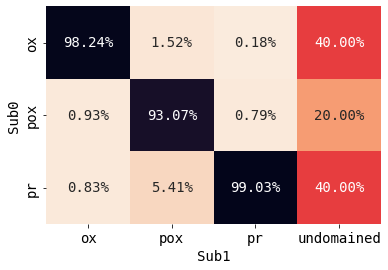

In [4]:
# CONFUSION MATRIX FOR SUB TO SUB COMPARISON

df3=pd.DataFrame()
gandu0=list(domains_of_created_block_centroids[0].values())
gandu1=list(domains_of_created_block_centroids[1].values())


df3["sub0"] = pd.Series(gandu0)
df3["sub1"] = pd.Series(gandu1)


point_confusion_matrix_for_sub = pd.crosstab(
    df3["sub0"], df3["sub1"], rownames=["Sub0"], colnames=["Sub1"]
)
point_confusion_matrix_for_sub = pd.DataFrame(point_confusion_matrix_for_sub)

mt = cm.figure(0)
gn = sns.heatmap(
    (point_confusion_matrix_for_sub) / (np.sum(point_confusion_matrix_for_sub)),
    cbar_kws={},
    annot=True,
    fmt=".2%",
    cmap="rocket_r",
    cbar=False,
)

cm.show()
# Uncomment the lines below to generate a report.
# print(
#     metrics.classification_report(
#         df["Points Domain"], df["Block Domains"], labels=colour_names, zero_division=1
#     )
# # )

In [5]:
print("Sub0:")
print(df3["sub0"].value_counts())


print(1 * "\n")
print("Sub1:")
print(df3["sub1"].value_counts())


Sub0:
pr     9521
ox     6595
pox    2892
Name: sub0, dtype: int64


Sub1:
pr            9395
ox            6648
pox           2960
undomained       5
Name: sub1, dtype: int64
